<a href="https://colab.research.google.com/github/FKz11/Neural_Network/blob/lesson-4/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22lesson_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## lesson-4

Библиотеки

In [ ]:
import numpy as np
from tensorflow.random import set_seed

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

In [ ]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10)

In [ ]:
def nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, start_kernel = 2, 
                              neurons = 2000, batch_size = 128, epochs = 7, verbose = 1, seed = 42):

    set_seed(seed)
    
    first_layer = np.empty(branch, dtype=object)
    
    first_input = layers.Input(shape=x_train.shape[1:],name='input') # shape = (32, 32, 3)

    for i in range(branch):
      if i > 1:                                                                                         
        conv = layers.Conv2D(start_filters*2**(i-1),2*(branch-1) + start_kernel - 2*i,                            # filters = 24, 24, 48, 96
                                            activation='relu',padding = 'same',name=f'conv_1_{i+1}')(first_input) # kernel_size = 8, 6, 4, 2
        first_layer[i] = layers.MaxPool2D(pool_size=(2**(i-1),2**(i-1)),name=f'pool_1_{i+1}')(conv)               # pool_size = 1, 1, 2, 4
      else:
        first_layer[i] = layers.Conv2D(start_filters,2*(branch-1) + start_kernel - 2*i,
                                       activation='relu',padding = 'same',name=f'conv_1_{i+1}')(first_input)

    layer_list = first_layer.copy()

    for i in range(branch-1):
      merge = layers.Concatenate(  axis =-1,name=f'merge_{i+2}' )([layer_list[i], first_layer[i+1]])                                                   
      conv = layers.Conv2D(start_filters*2**(i+1),2*(branch-1) + start_kernel - 2*(i+1),   # filters = 48, 96, 192
                           activation='relu',padding = 'same',name=f'conv_{i+2}')(merge)   # kernel_size = 6, 4, 2
      layer_list[i+1] = layers.MaxPool2D(pool_size=(2,2),name=f'pool_{i+2}')(conv)

    flatten = layers.Flatten(name='flatten')(layer_list[branch-1]) # input_shape = (4, 4, 192)
    
    dense_one=layers.Dense(neurons, activation='relu', name='dense_one')(flatten) # input_shape = (3072)
    
    dense_two=layers.Dense(y_train.shape[1], activation='softmax', name='dense_two')(dense_one)
    
    model = Model(inputs=first_input, outputs=dense_two)
    
    # компиляция модели
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    hh = model.fit(x_train, y_train, shuffle=True,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=verbose,
                   validation_data=(x_test, y_test))
    
    return model, hh.history

In [ ]:
model, hh = nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, start_kernel = 2, 
                                      neurons = 2000, batch_size = 128, epochs = 7, verbose = 1, seed = 42)

Epoch 1/7
391/391 [==============================] - 44s 106ms/step - loss: 1.4589 - accuracy: 0.4720 - val_loss: 1.1224 - val_accuracy: 0.6020
Epoch 2/7
391/391 [==============================] - 38s 98ms/step - loss: 1.0140 - accuracy: 0.6420 - val_loss: 0.9512 - val_accuracy: 0.6646
Epoch 3/7
391/391 [==============================] - 39s 99ms/step - loss: 0.8287 - accuracy: 0.7088 - val_loss: 0.8532 - val_accuracy: 0.7060
Epoch 4/7
391/391 [==============================] - 40s 101ms/step - loss: 0.7079 - accuracy: 0.7519 - val_loss: 0.7897 - val_accuracy: 0.7256
Epoch 5/7
391/391 [==============================] - 39s 99ms/step - loss: 0.5952 - accuracy: 0.7913 - val_loss: 0.7535 - val_accuracy: 0.7455
Epoch 6/7
391/391 [==============================] - 39s 99ms/step - loss: 0.4868 - accuracy: 0.8291 - val_loss: 0.7683 - val_accuracy: 0.7506
Epoch 7/7
391/391 [==============================] - 39s 99ms/step - loss: 0.3766 - accuracy: 0.8693 - val_loss: 0.7457 - val_accuracy: 0.75

In [ ]:
{key: value[-1] for key, value in hh.items()}

{'accuracy': 0.8692799806594849,
 'loss': 0.3765803575515747,
 'val_accuracy': 0.7544999718666077,
 'val_loss': 0.7457447648048401}

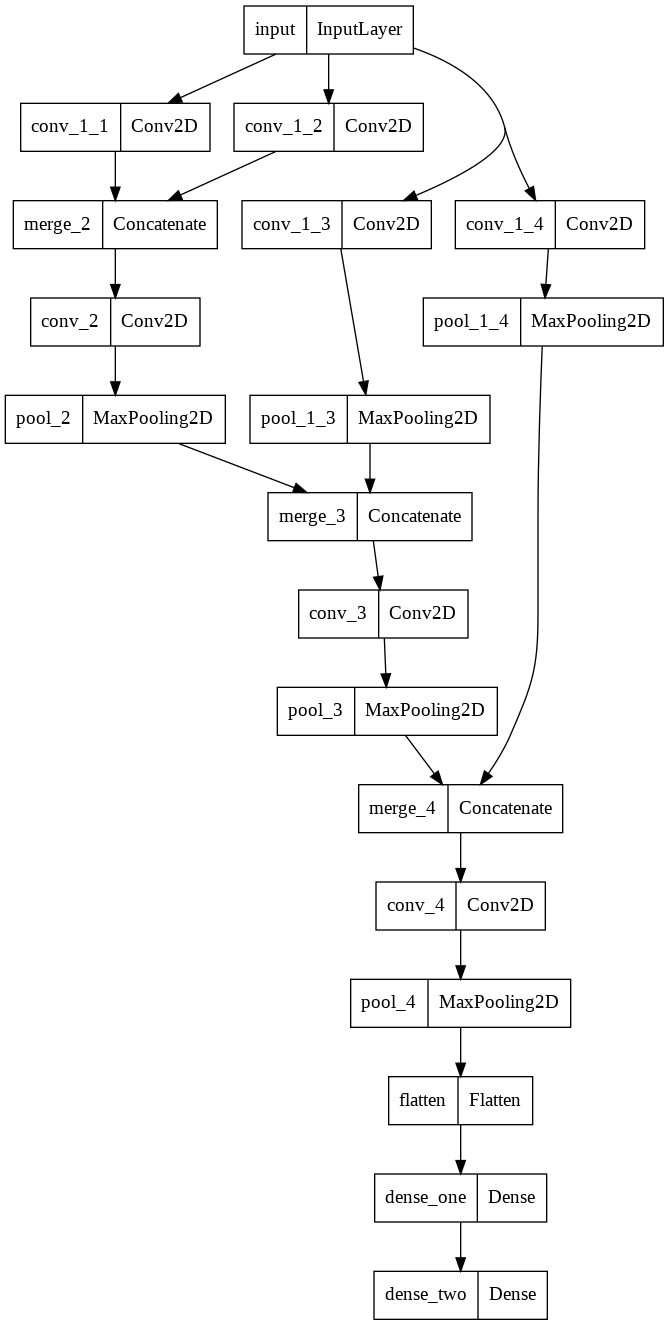

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_1 (Conv2D)              (None, 32, 32, 24)   4632        ['input[0][0]']                  
                                                                                                  
 conv_1_2 (Conv2D)              (None, 32, 32, 24)   2616        ['input[0][0]']                  
                                                                                                  
 merge_2 (Concatenate)          (None, 32, 32, 48)   0           ['conv_1_1[0][0]',               
                                                                  'conv_1_2[0][0]']           

Пускай количество эпох = 10. Итоговой метрикой будем считать лучшую за 10 эпох.

### branch

При увеличении количество веток увилививается как ширина нейронной сети, так и длина. Но так как после каждой свёртке идёт MaxPool с pool_size = (2,2), а начальный размер изображения 32x32, то максимальное количество веток будет 6, причём размеры конечных изображений будут 1x1 с количество фильтров равным start_filters*32.

In [ ]:
%%time

branch_list = list(range(2, 7))

metrics_branch = []

for branch in branch_list:
  metric = np.max(nn_conv(x_train, x_test, y_train, y_test, branch = branch, start_filters = 24, 
              start_kernel = 2, neurons = 2000, batch_size = 128, epochs = 10, verbose = 0, seed = 42)[1]['val_accuracy'])
  print(f'{branch} - {metric}')
  metrics_branch.append(metric)

In [ ]:
plt.plot(branch_list, metrics_branch, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('branch', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Лучшее количество branch = 4, хотя это скорее связано с размерами выходных изображений после MaxPool, которые будут 4x4 с 192 фильтрами.

### start_filters

In [ ]:
%%time

start_filters_list = [12, 18, 24, 36, 48]

metrics_start_filters = []

for start_filters in start_filters_list:
  metric = np.max(nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = start_filters, 
              start_kernel = 2, neurons = 2000, batch_size = 128, epochs = 10, verbose = 0, seed = 42)[1]['val_accuracy'])
  print(f'{start_filters} - {metric}')
  metrics_start_filters.append(metric)

In [ ]:
plt.plot(start_filters_list, metrics_start_filters, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('start_filters', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Лучшее количество start_filters = 24.

### start_kernel

In [ ]:
%%time

start_kernel_list = [1, 2, 3, 4, 5]

metrics_start_kernel = []

for start_kernel in start_kernel_list:
  metric = np.max(nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, 
              start_kernel = start_kernel, neurons = 2000, batch_size = 128, epochs = 10, verbose = 0, seed = 42)[1]['val_accuracy'])
  print(f'{start_kernel} - {metric}')
  metrics_start_kernel.append(metric)

In [ ]:
plt.plot(start_kernel_list, metrics_start_kernel, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('start_kernel', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Лучшее количество start_kernel = 2, хотя оно и чётное, оно даёт лучшую метрику.

### neurons

In [ ]:
%%time

neurons_list = [1000, 2000, 3000, 5000, 10000]

metrics_neurons = []

for neurons in neurons_list:
  metric = np.max(nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, 
              start_kernel = 2, neurons = neurons, batch_size = 128, epochs = 10, verbose = 0, seed = 42)[1]['val_accuracy'])
  print(f'{neurons} - {metric}')
  metrics_neurons.append(metric)

In [ ]:
plt.plot(neurons_list, metrics_neurons, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('neurons', fontsize=15)
plt.xscale('log')
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Лучшее количество neurons = 2000. При входных данных размером 4x4x24x2^3 = 3072.

### batch_size

In [ ]:
%%time

batch_size_list = [32, 64, 128, 256, 512]

metrics_batch_size = []

for batch_size in batch_size_list:
  metric = np.max(nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, 
              start_kernel = 2, neurons = 2000, batch_size = batch_size, epochs = 10, verbose = 0, seed = 42)[1]['val_accuracy'])
  print(f'{batch_size} - {metric}')
  metrics_batch_size.append(metric)

In [ ]:
plt.plot(batch_size_list, metrics_batch_size, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('batch_size', fontsize=15)
plt.xscale('log')
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Лучшее количество batch_size = 128.

### epochs

In [ ]:
metrics_epochs = nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 24, 
              start_kernel = 2, neurons = 2000, batch_size = 128, epochs = 20, verbose = 1, seed = 42)[1]['val_accuracy']

In [ ]:
plt.plot(list(range(1,11)), metrics_epochs, color = 'red')
plt.title('NN_accuracy', fontsize=20)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

На 5 эпохе можно сказать, что нейронная сеть сходится. Дальше ошибка начинает расти из-за переобучения, хотя метрика прыгает и уже на 7 эпохе довольно больше чем на 5. Так же из-за переобучения метрика на трейне стримится к 1.

#### Вывод:

Я постарался сделать необычную нелинейную свёрточную нейронную сеть, учитывая заканомерности изученной сети AlexNet, а точнее: сначала задаём большой размер ядра для свёртки, далее уменьшаем размер ядра свёртки, увиличиваем количество фильтров и используем связки, свёртка - пулинг. Далее выпремляем наш конечный тензор, прогоняем его через полносвязный нейронный слой и выводим на конечные 10 выходных нейронов наш ответ в вероятностном виде (от 0 до 1) с помощью функции активации softmax.

Идея моей нейронной сети, чтобы на каждом этапе свёртка - пулинг, нейронная сеть вспоминала изначальные данные той же размерности, но свёрнутые ядрами разных размеров. Такая компоновка данных на каждом этапе, должна давать более интересные резуьтаты, чем обычная линейная модель.

Я проэксперементировал с гиперпараметрами моей нейронной сети и сделал выводы для каждого гиперпараметра.

(Пока еще не успел перезапустить полностью весь ноутбук, чтобы показать графики, сделаю это утром 29.03.2022).